From https://scikit-learn.org/stable/auto_examples/decomposition/plot_image_denoising.html

In [1]:
%matplotlib inline


# Inverse problems using dictionary learning


An example comparing the effect of reconstructing noisy fragments
of a face image using firstly online `DictionaryLearning` and
various transform methods.

The dictionary is fitted on the undistorted left half of the image, and
subsequently used to reconstruct the right half. Note that even better
performance could be achieved by fitting to a large dataset of images.

A common practice for evaluating the results of image denoising is by looking
at the difference between the reconstruction and the original image. If the
reconstruction is perfect this will look like Gaussian noise.

It can be seen from the plots that the results of `omp` with two
non-zero coefficients is a bit less biased than when keeping only one
(the edges look less prominent). It is in addition closer from the ground
truth in Frobenius norm.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from PIL import Image
import requests
from io import BytesIO

import numpy as np
from scipy import ndimage

In [4]:
img_urls = ['https://cims.nyu.edu/~cfgranda/foto.jpg']

In [5]:
img_array = []

for url in img_urls:
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.convert('L')
    img = np.array(img)
    img_array.append(img)

In [6]:
face = img_array[0]

Automatically created module for IPython interactive environment
Distorting image...
Extracting reference patches...
done in 0.12s.
Learning the dictionary...
done in 5.24s.
Extracting noisy patches... 
done in 0.04s.
Orthogonal Matching Pursuit
1 atom...
done in 3.26s.
Orthogonal Matching Pursuit
2 atoms...
done in 8.08s.
Orthogonal Matching Pursuit
5 atoms...
done in 13.53s.


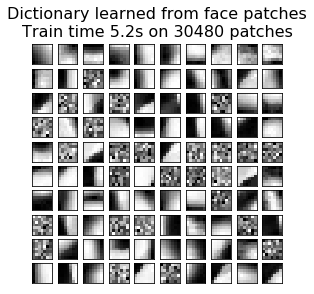

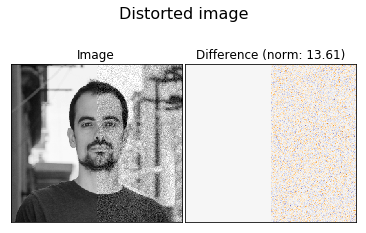

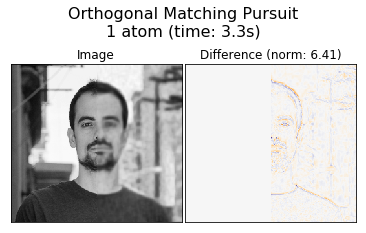

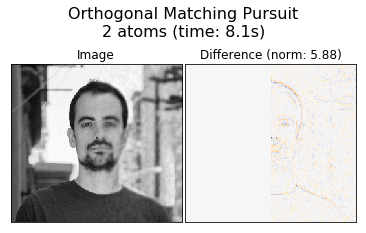

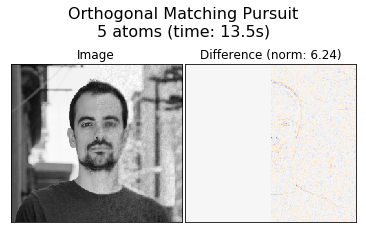

In [7]:
print(__doc__)

from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d



# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
face = face / 255.

# downsample for higher speed
face = face[::4, ::4] + face[1::4, ::4] + face[::4, 1::4] + face[1::4, 1::4]
face /= 4.0
face = face[:, :-1]
height, width = face.shape

# Distort the right half of the image
print('Distorting image...')
distorted = face.copy()
distorted[:, width // 2:] += 0.075 * np.random.randn(height, width // 2)

# Extract all reference patches from the left half of the image
print('Extracting reference patches...')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print('done in %.2fs.' % (time() - t0))

# #############################################################################
# Learn the dictionary from reference patches

print('Learning the dictionary...')
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1, n_iter=500)
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from face patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)


# #############################################################################
# Display the distorted image

def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(5, 3.3))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference ** 2)))
    plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)

show_with_diff(distorted, face, 'Distorted image')

# #############################################################################
# Extract noisy patches and reconstruct them using the dictionary

print('Extracting noisy patches... ')
t0 = time()
data = extract_patches_2d(distorted[:, width // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time() - t0))

transform_algorithms = [
    ('Orthogonal Matching Pursuit\n1 atom', 'omp',
     {'transform_n_nonzero_coefs': 1}),
    ('Orthogonal Matching Pursuit\n2 atoms', 'omp',
     {'transform_n_nonzero_coefs': 2}), 
    ('Orthogonal Matching Pursuit\n5 atoms', 'omp',
     {'transform_n_nonzero_coefs': 5})]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + '...')
    reconstructions[title] = face.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2:] = reconstruct_from_patches_2d(
        patches, (height, width // 2))
    dt = time() - t0
    print('done in %.2fs.' % dt)
    show_with_diff(reconstructions[title], face,
                   title + ' (time: %.1fs)' % dt)

plt.show()

## No Corruption

Extracting patches from right half... 
done in 0.05s.
Orthogonal Matching Pursuit
1 atom...
done in 3.71s.
Orthogonal Matching Pursuit
2 atoms...
done in 7.99s.
Orthogonal Matching Pursuit
5 atoms...
done in 14.15s.
Orthogonal Matching Pursuit
20 atoms...
done in 58.88s.


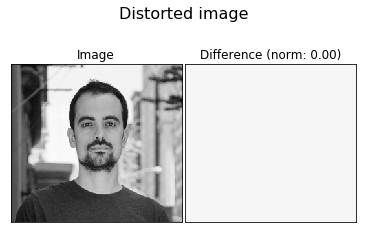

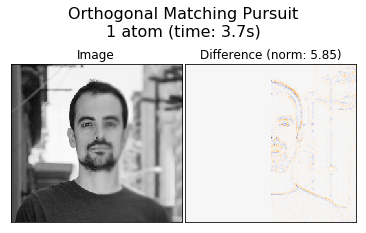

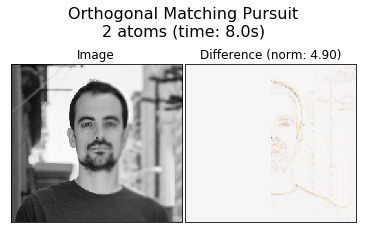

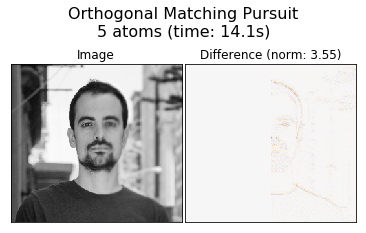

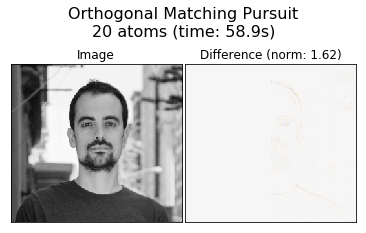

In [14]:

distorted = face.copy()



print('Extracting patches from right half... ')
t0 = time()
data = extract_patches_2d(distorted[:, width // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time() - t0))

transform_algorithms = [
    ('Orthogonal Matching Pursuit\n1 atom', 'omp',
     {'transform_n_nonzero_coefs': 1}),
    ('Orthogonal Matching Pursuit\n2 atoms', 'omp',
     {'transform_n_nonzero_coefs': 2}), 
    ('Orthogonal Matching Pursuit\n5 atoms', 'omp',
     {'transform_n_nonzero_coefs': 5}),
    ('Orthogonal Matching Pursuit\n20 atoms', 'omp',
     {'transform_n_nonzero_coefs': 20})]

show_with_diff(distorted, face, 'Distorted image')
reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + '...')
    reconstructions[title] = face.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2:] = reconstruct_from_patches_2d(
        patches, (height, width // 2))
    dt = time() - t0
    print('done in %.2fs.' % dt)
    show_with_diff(reconstructions[title], face,
                   title + ' (time: %.1fs)' % dt)

plt.show()

## Deblurring

# $ || y - BDa  ||_2^2$

In [8]:
from scipy.ndimage.filters import gaussian_filter

Distorting image...
Extracting blurred patches... 
done in 0.04s.
Orthogonal Matching Pursuit
1 atom...
done in 2.73s.
Orthogonal Matching Pursuit
2 atoms...
done in 5.19s.
Orthogonal Matching Pursuit
5 atoms...
done in 16.24s.
Orthogonal Matching Pursuit
20 atoms...
done in 59.75s.


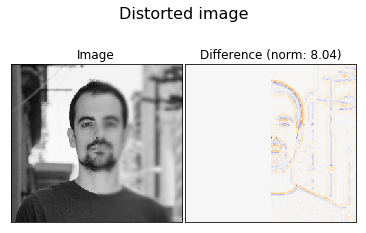

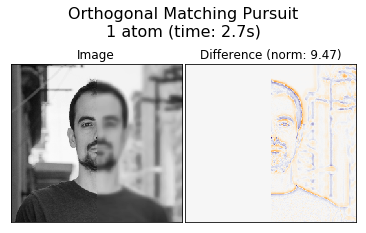

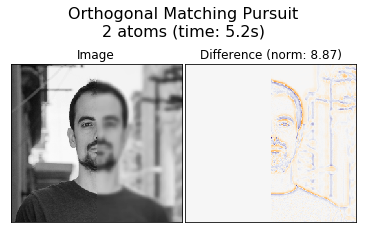

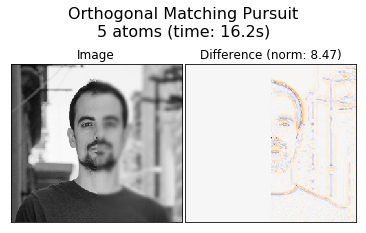

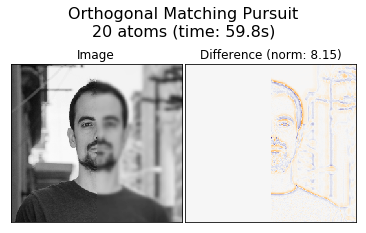

In [13]:
print('Distorting image...')
distorted = face.copy()
distorted[:, width // 2:] =  gaussian_filter(distorted[:, width // 2:], sigma=2)


print('Extracting blurred patches... ')
t0 = time()
data = extract_patches_2d(distorted[:, width // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time() - t0))

transform_algorithms = [
    ('Orthogonal Matching Pursuit\n1 atom', 'omp',
     {'transform_n_nonzero_coefs': 1}),
    ('Orthogonal Matching Pursuit\n2 atoms', 'omp',
     {'transform_n_nonzero_coefs': 2}), 
    ('Orthogonal Matching Pursuit\n5 atoms', 'omp',
     {'transform_n_nonzero_coefs': 5}),
    ('Orthogonal Matching Pursuit\n20 atoms', 'omp',
     {'transform_n_nonzero_coefs': 20})]

show_with_diff(distorted, face, 'Distorted image')
reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + '...')
    reconstructions[title] = face.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2:] = reconstruct_from_patches_2d(
        patches, (height, width // 2))
    dt = time() - t0
    print('done in %.2fs.' % dt)
    show_with_diff(reconstructions[title], face,
                   title + ' (time: %.1fs)' % dt)

plt.show()

## Random Inpainting

Distorting image...
Extracting occluded patches... 
done in 0.04s.
Orthogonal Matching Pursuit
1 atom...
done in 2.94s.
Orthogonal Matching Pursuit
2 atoms...
done in 7.33s.
Orthogonal Matching Pursuit
5 atoms...
done in 12.65s.


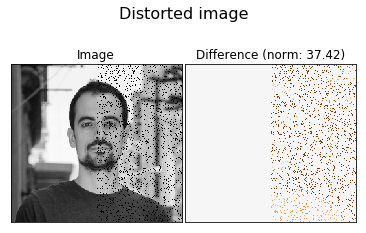

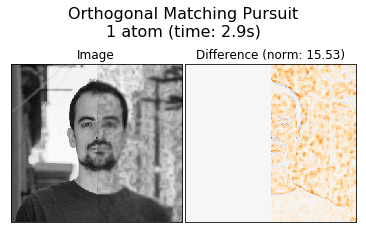

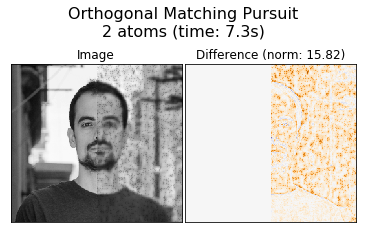

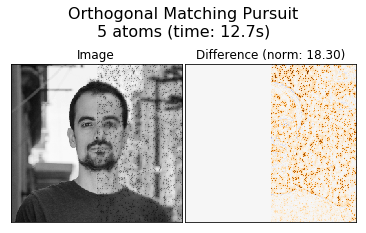

In [10]:
thres_prob = 0.1
print('Distorting image...')
distorted = face.copy()
distorted[:, width // 2:] *= (np.random.random(size = distorted[:, width // 2:].shape) > thres_prob)


print('Extracting occluded patches... ')
t0 = time()
data = extract_patches_2d(distorted[:, width // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time() - t0))

transform_algorithms = [
    ('Orthogonal Matching Pursuit\n1 atom', 'omp',
     {'transform_n_nonzero_coefs': 1}),
    ('Orthogonal Matching Pursuit\n2 atoms', 'omp',
     {'transform_n_nonzero_coefs': 2}), 
    ('Orthogonal Matching Pursuit\n5 atoms', 'omp',
     {'transform_n_nonzero_coefs': 5})]

show_with_diff(distorted, face, 'Distorted image')
reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + '...')
    reconstructions[title] = face.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2:] = reconstruct_from_patches_2d(
        patches, (height, width // 2))
    dt = time() - t0
    print('done in %.2fs.' % dt)
    show_with_diff(reconstructions[title], face,
                   title + ' (time: %.1fs)' % dt)

plt.show()